In [17]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
time_list = [t for t in range(0,5001,120)]
elo_list = ['low','medium','high']
views = ['p1_','p2_']

In [3]:
#master data
with open(f'masterdata/full_resource_masterdata_dict.pkl', 'rb') as f:
        resource_masterdata = pickle.load(f)

def print_txt(msg: str):
    print(msg, end = '\r')
    text_file = open("Outputs/resource_annot.txt", "w")
    text_file.write(msg)
    text_file.close()


In [205]:
viz_path = 'Visualizations/'

In [ ]:
if True:
    for elo in elo_list:
        for tf in time_list:
                print_txt(f'Elo {elo}, TF {tf}')
                #load data
                data_path = f"data/minn/elo_{elo}/"
                filename = f"recordfile_tab_data_{tf}.pkl"
                with open(data_path + filename, 'rb') as f:
                    tab_data = pickle.load(f)

                #init values
                tab_total_resources = {}
                total_resources = {}
                

                for view in views:
                    tab_total_resources[view] = []

                #collect resource values
                for index, row in tab_data.iterrows():

                    #init total resource values
                    for view in views:
                        total_resources[view] = {}
                        total_resources[view]['total'] = 0
                        for res_key in resources:
                            total_resources[view][res_key] = 0
                            
                    #sum up total resource values
                    for key in row.keys():
                            view_key = key[:3]
                            obj_key = key [3:]
                            for view in views:
                                if view == view_key:
                                    if obj_key in resource_masterdata:
                                        total_resources[view]['total'] += row[key] * resource_masterdata[obj_key]['total_resources']
                                        for res_key in resources:
                                            if res_key in resource_masterdata[obj_key]:
                                                total_resources[view][res_key] +=  row[key] * resource_masterdata[obj_key][res_key]
                    #save total resource values
                    for view in views:
                        tab_total_resources[view].append(total_resources[view])

                #write into tabdata
                for view in views:
                    tab_data[f'{view}_total_resources'] = tab_total_resources[view]

                #write back 

                data_path = f"data/minn/resource_annotated/elo_{elo}/"
                filename = f"recordfile_tab_data_{tf}.pkl"

                output = open(data_path + filename , 'wb')
                pickle.dump(tab_data, output)
                output.close()



In [99]:
# if duration > tf
#get diffrence per elo class for winner and loser
mean_res = {}
res_dict = {}

for elo in elo_list:
    res_dict[elo] = {}
    for tf in time_list:
        data_path = f"data/minn/resource_annotated/elo_{elo}/"
        filename = f"recordfile_tab_data_{tf}.pkl"
        
        with open(data_path + filename, 'rb') as f:
            tab_data = pickle.load(f)
        
        #only take running matches into accound
        tab_data = tab_data[tab_data['duration']>= tf]
        loser_res = []
        winner_res = []
        diff_res = []
        
        #get winner loser resources
        for index, row in tab_data.iterrows():
            if row['winner'] == 0:
                winner_res.append(row['p1__total_resources'])
                loser_res.append(row['p2__total_resources'])
            else:
                winner_res.append(row['p2__total_resources'])
                loser_res.append(row['p1__total_resources'])
            
            diff_res.append(winner_res[-1]-loser_res[-1])
            
        
        tab_data['winner_res'] = winner_res
        tab_data['loser_res'] = loser_res
        
        mean_res[f'{elo}_{tf}'] = {'elo': elo,
                    'tf': tf,
                    'mean_res': (tab_data['p1__total_resources'].mean() + tab_data['p2__total_resources'].mean())/2,
                    'winner_res': tab_data['winner_res'].mean(),
                    'loser_res':  tab_data['loser_res'].mean()}


        res_dict[elo][tf] = {'winner_res': winner_res,
                             'loser_res': loser_res,
                              'diff_res': diff_res}

output = open('data/minn/resource_annotated/mean_res.pkl' , 'wb')
pickle.dump(mean_res, output)
output.close()

In [104]:
output = open('data/minn/resource_annotated/res_dict.pkl' , 'wb')
pickle.dump(res_dict, output)
output.close()

In [165]:
df = pd.DataFrame.from_dict(mean_res,orient='index')
df['diff_res'] = df['winner_res'] - df['loser_res']
df

,elo,tf,mean_res,winner_res,loser_res,diff_res
low_0,low,0,7.430940,8.350405,6.511475,1.838930
low_120,low,120,388.458848,395.936736,380.980959,14.955777
low_240,low,240,746.863305,760.974926,732.751685,28.223241
low_360,low,360,1128.260585,1151.912123,1104.609048,47.303075
low_480,low,480,1558.298942,1603.133939,1513.463945,89.669993
...,...,...,...,...,...,...
high_4440,high,4440,89098.341463,89243.934959,88952.747967,291.186992
high_4560,high,4560,90667.989130,90868.728261,90467.250000,401.478261
high_4680,high,4680,93513.590278,93121.347222,93905.833333,-784.486111
high_4800,high,4800,95599.358333,95228.900000,95969.816667,-740.916667


In [168]:
df['mean_rate'] = df['mean_res']/df['tf']
df['winner_rate'] = df['winner_res']/df['tf']
df['loser_rate'] = df['loser_res']/df['tf']

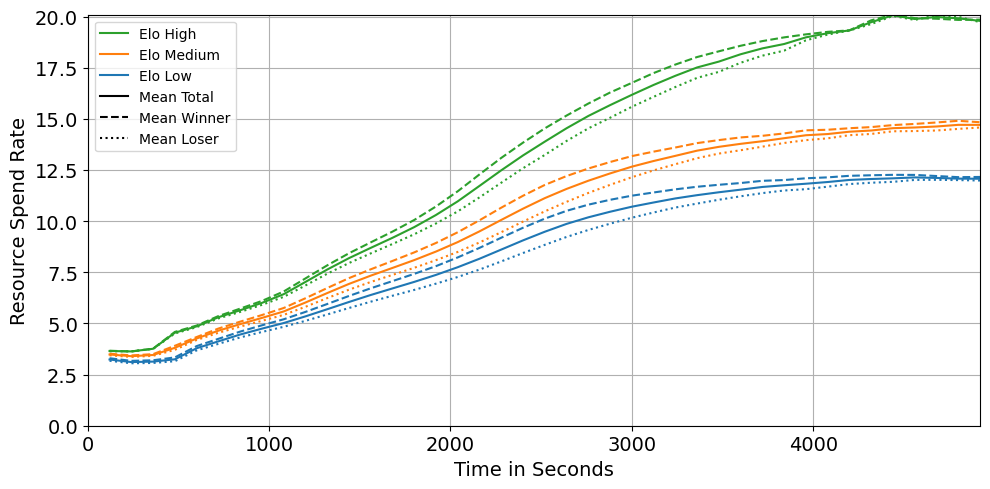

In [209]:
name = "resource_rate"
x,y=([0],[0])

ax1 = sns.lineplot(data=df,x='tf',y='mean_rate',hue='elo')
ax2 = sns.lineplot(data=df,x='tf',y='winner_rate',hue='elo', linestyle='--',legend=False)
ax3 = sns.lineplot(data=df,x='tf',y='loser_rate',hue='elo', linestyle=':',legend=False)
lgd_dummy1, = plt.plot(x[0], y[0], color='tab:green', linestyle='solid')
lgd_dummy2, = plt.plot(x[0], y[0], color='tab:orange', linestyle='solid')
lgd_dummy3, = plt.plot(x[0], y[0], color='tab:blue', linestyle='solid')
lgd_dummy4, = plt.plot(x[0], y[0], color='black', linestyle='solid')
lgd_dummy5, = plt.plot(x[0], y[0], color='black', linestyle='--')
lgd_dummy6, = plt.plot(x[0], y[0], color='black', linestyle=':')

plt.legend([lgd_dummy1,lgd_dummy2,lgd_dummy3,lgd_dummy4,lgd_dummy5,lgd_dummy6],['Elo High','Elo Medium','Elo Low', 'Mean Total','Mean Winner','Mean Loser'])


plt.xlabel("Time in Seconds",fontsize=14)
plt.ylabel("Resource Spend Rate",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.margins(x=0,y=0)
plt.grid()
plt.tight_layout()
plt.savefig(viz_path+name + '.pdf',format='pdf',facecolor='white')
plt.show()

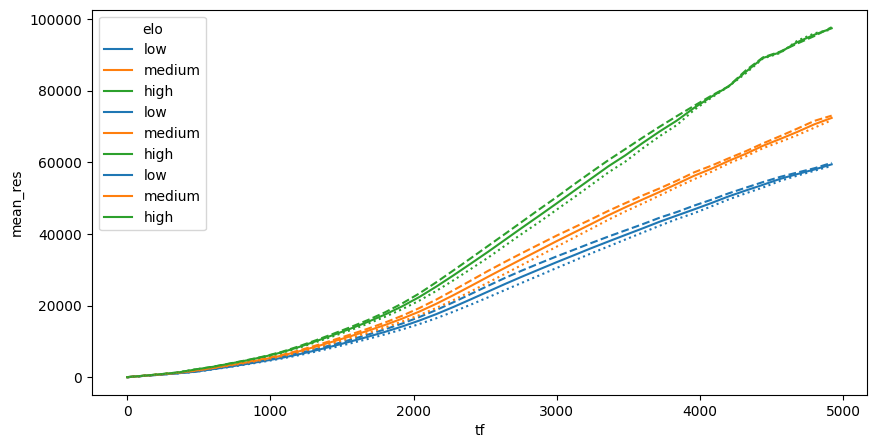

In [152]:
ax1 = sns.lineplot(data=df,x='tf',y='mean_res',hue='elo')
ax2 = sns.lineplot(data=df,x='tf',y='winner_res',hue='elo', linestyle='--')
ax3 = sns.lineplot(data=df,x='tf',y='loser_res',hue='elo', linestyle=':')


plt.show()

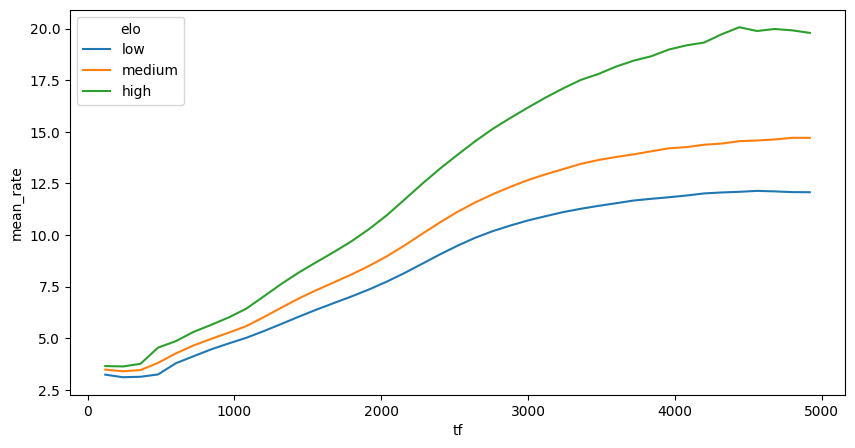

In [134]:
df['mean_rate'] = df['mean_res']/df['tf']
sns.lineplot(data=df,x='tf',y='mean_rate',hue='elo')
plt.show()

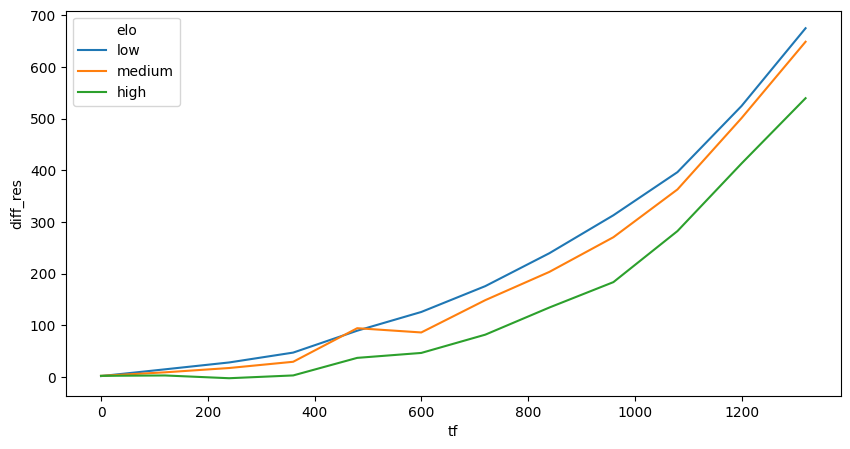

In [151]:
sns.lineplot(data=df[df['tf']<=1340],x='tf',y='diff_res',hue='elo')
plt.show()

<ipython-input-164-d178bf6562ab>:5: UserWarning: Legend does not support <AxesSubplot:xlabel='tf', ylabel='mean_res'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend([line1,line1,line1], ['Cold', 'Medium', 'Hot'])


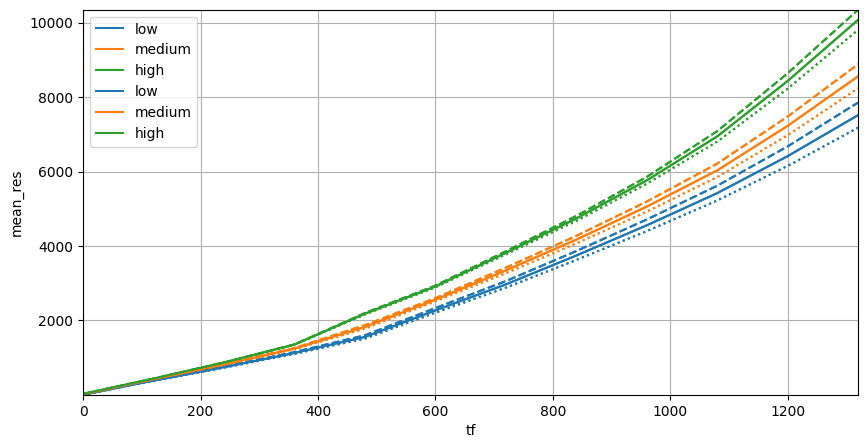

In [164]:
early_df = df[df['tf']<=1340]
line1 = sns.lineplot(data=early_df,x='tf',y='mean_res',hue='elo')
sns.lineplot(data=early_df,x='tf',y='winner_res',hue='elo', linestyle='--',legend=False)
ax =sns.lineplot(data=early_df,x='tf',y='loser_res',hue='elo', linestyle=':',legend=False)
ax.legend([line1,line1,line1], ['Cold', 'Medium', 'Hot'])

plt.grid()
plt.legend()
plt.show()

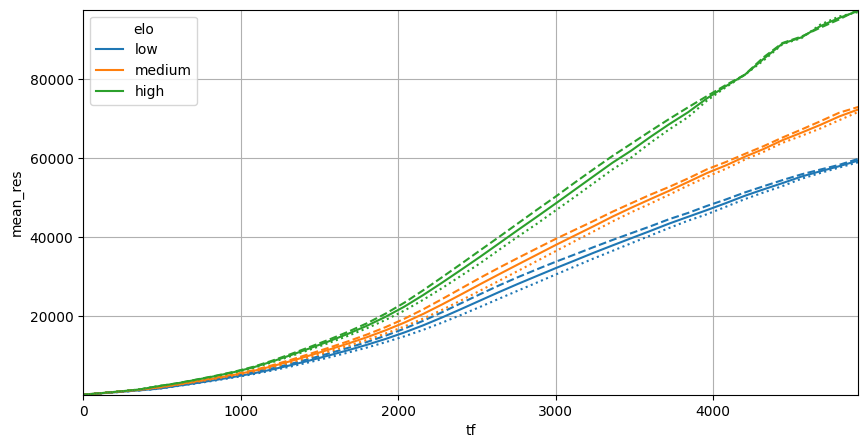

In [159]:

sns.lineplot(data=df,x='tf',y='mean_res',hue='elo')
sns.lineplot(data=df,x='tf',y='winner_res',hue='elo', linestyle='--',legend=False)
sns.lineplot(data=df,x='tf',y='loser_res',hue='elo', linestyle=':',legend=False)
plt.margins(x=0,y=0)
plt.grid()
plt.show()

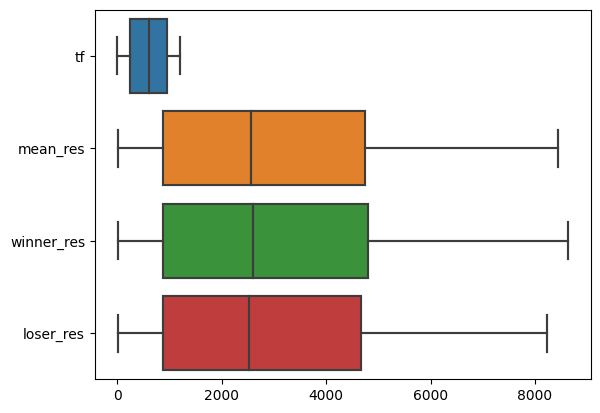

In [ ]:
sns.boxplot(data=early_df,orient='h')
plt.show()

In [101]:
    
winner_data = []
loser_data = []
diff_data = []

for elo in res_dict:

    
    for tf in res_dict[elo]:
        winner_data.extend([[elo,tf,v] for v in res_dict[elo][tf]['winner_res']])
        loser_data.extend([[elo,tf,v] for v in res_dict[elo][tf]['loser_res']])
        diff_data.extend([[elo,tf,v] for v in res_dict[elo][tf]['diff_res']])
        

In [139]:
p = ['winner','loser','diff']
dfs={}


dfs['winner'] = pd.DataFrame(winner_data, columns=['elo','tf','res'])
dfs['loser'] = pd.DataFrame(loser_data, columns=['elo','tf','res'])
dfs['diff'] = pd.DataFrame(diff_data, columns=['elo','tf','res'])


for key in dfs:
    dfs[key]['view'] = key
    dfs[key]['key'] =dfs[key]['elo'] + '_' + key
    
    
full_df = pd.concat([dfs['winner'],dfs['loser']])

In [ ]:
hue_order = ['low_winner','low_loser', 'medium_winner', 'medium_loser', 'high_winner', 'high_loser']

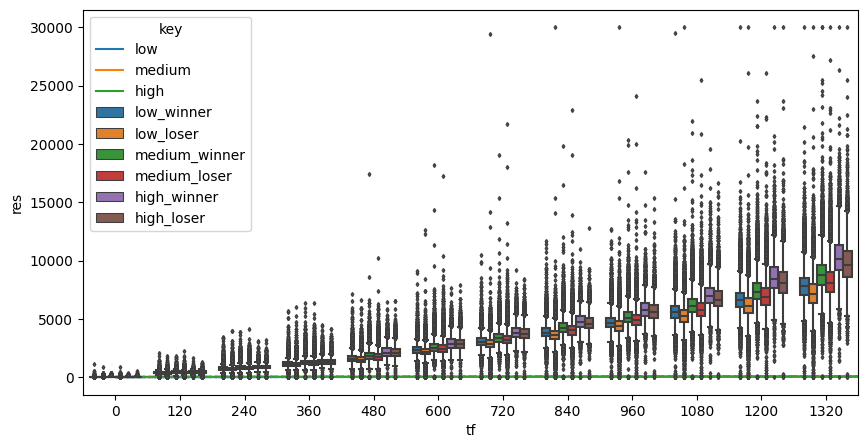

In [162]:
plt.rcParams["figure.figsize"] = (10,5)
full_df['res']=np.where(full_df['res']>=30000,30000,full_df['res'])
ax1=sns.boxplot(data=full_df[full_df['tf']<=1320],x='tf',y='res',hue='key',hue_order = hue_order, flierprops = dict(markerfacecolor = '0.50', markersize = 2))
#ax2=sns.boxplot(data=loser_df[loser_df['tf']<=1340],x='tf',y='res',color='red')
plt.show()

In [138]:
diff_df = pd.DataFrame(diff_data, columns=['elo','tf','res'])
diff_df

,elo,tf,res
0,low,0,0.0
1,low,0,-50.0
2,low,0,0.0
3,low,0,0.0
4,low,0,0.0
...,...,...,...
2672496,high,4920,-35757.0
2672497,high,4920,8218.0
2672498,high,4920,35639.0
2672499,high,4920,-39016.0


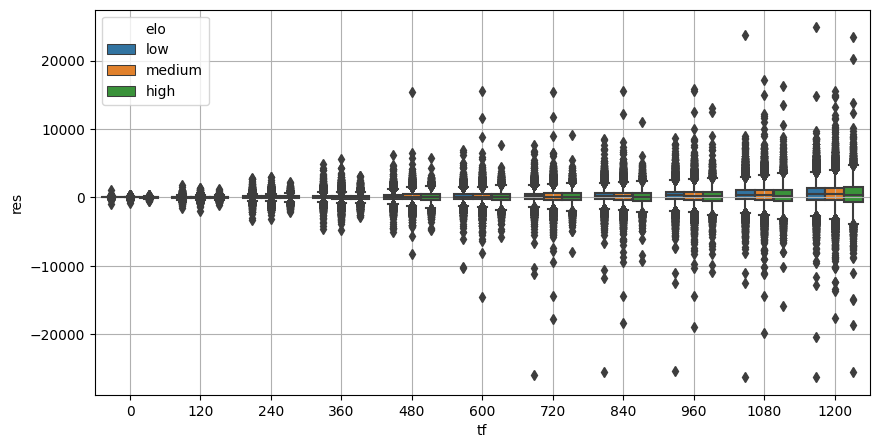

In [147]:
x1=sns.boxplot(data=diff_df[diff_df['tf']<=1200],x='tf',y='res',hue='elo')
plt.grid()
plt.show()

In [142]:
diff_df['rate'] = diff_df['res']/diff_df['tf']

/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/niel/.conda/e

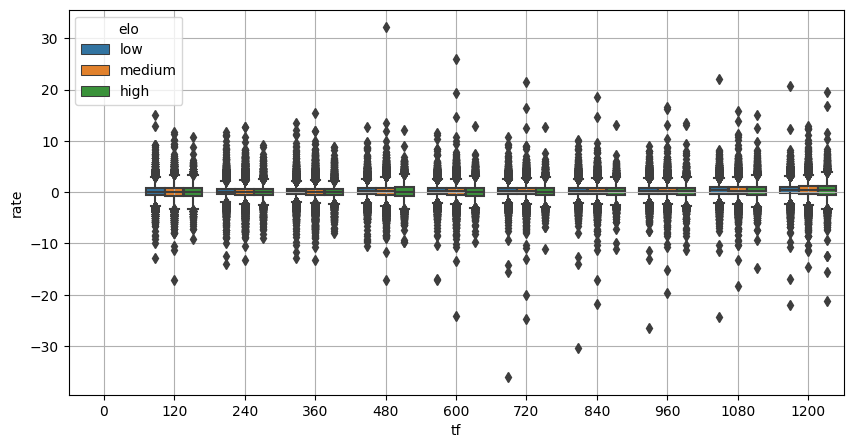

In [148]:
x1=sns.boxplot(data=diff_df[diff_df['tf']<=1200],x='tf',y='rate',hue='elo')
plt.grid()
plt.show()